In [ ]:
# !pip install transformers
# !pip install torch

In [6]:
import pandas as pd
import numpy as np

In [9]:
df=pd.read_csv("BeerDataScienceProject.csv", encoding='latin-1')
print(len(df))

528870


In [10]:
df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

In [11]:
df[:3]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604


## Cleaning duplicate rows 

In [12]:
print(len(df[df.duplicated()])) # check if the data has complete duplicate row
df=df.drop_duplicates()

0


In [13]:
# check if the drinker rated same beer more than once, if so, then keep the beer row with highest rating.
df = df.sort_values('review_overall', ascending=False)
df = df.drop_duplicates(subset=['review_profileName', 'beer_name'], keep='first')
print(len(df))

522928


## Cleaning rows with null values

In [14]:
print(len(df.dropna()))
df=df.dropna() 

502691


## Check if rating given by drinker is <1 or >5.

In [15]:
df = df[( (df['review_overall'] >= 1) | (df['review_overall'] <=5) ) |
        ( (df['review_palette'] >= 1) | (df['review_palette'] <=5) ) |
        ( (df['review_appearance'] >= 1) | (df['review_appearance'] <= 5) ) |
        ( (df['review_taste'] >= 1) | (df['review_taste'] <=5) ) |
        ( (df['review_aroma'] >= 1) | (df['review_aroma'] <=5) ) ]
print(len(df))

502691


# 1. Rank top 3 Breweries which produce the strongest beers?

In [1]:
avg_abv = df.groupby(['beer_brewerId'])['beer_ABV'].mean()
# print(type(avg_abv))
top3 = pd.DataFrame(avg_abv)
top3 = top3.sort_values(by=['beer_ABV'], ascending=False)[:3]
top3

# 2. Which year did beers enjoy the highest ratings?

In [16]:
df['review_time'].dtypes

dtype('int64')

In [17]:
time=pd.to_datetime(df['review_time'], unit='s')
df['review_year']=pd.DatetimeIndex(time).year

In [18]:
avg_review = df.groupby(['beer_beerId'])['review_overall','review_taste','review_aroma',
                                        'review_appearance','review_palette','beer_ABV'].mean()
# print(type(avg_review))
top1 = pd.DataFrame(avg_review)
top1 = top1.sort_values(['review_overall', 'review_aroma','review_appearance','review_palette',
                         'review_taste','beer_ABV'], ascending=[False,False, False, False, False,False])
top1=top1[:1].reset_index()
top1['review year']=df[df['beer_beerId']==top1['beer_beerId'][0]]['review_year'].values[0]
print("In ",top1['review year'][0],"year, beers enjoyed with the highest ratings")
top1

/home/sontakke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In  2002 year, beers enjoyed with the highest ratings


,beer_beerId,review_overall,review_taste,review_aroma,review_appearance,review_palette,beer_ABV,review year
0,1734,5.0,5.0,5.0,5.0,5.0,10.0,2002


# 3. Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

## Approach 1: 

In [19]:
features = df[['review_overall','review_taste','review_aroma','review_appearance','review_palette']]
pearson_corr = features.corr()
pearson_corr

,review_overall,review_taste,review_aroma,review_appearance,review_palette
review_overall,1.000000,0.688862,0.780238,0.482756,0.597737
review_taste,0.688862,1.000000,0.722306,0.551515,0.600343
review_aroma,0.780238,0.722306,1.000000,0.530705,0.702963
review_appearance,0.482756,0.551515,0.530705,1.000000,0.544308
review_palette,0.597737,0.600343,0.702963,0.544308,1.000000


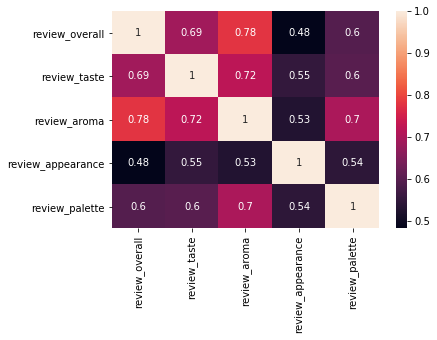

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pearson_corr, annot=True)
plt.show()

In [21]:
print("The above heat map tells that aroma is most important factor followed by taste, palette and appearance ")

The above heat map tells that aroma is most important factor followed by taste, palette and appearance 


## Approach 2:

Feature:  review_taste  || Score:  0.25733598215962894
Feature:  review_aroma  || Score:  0.5523229356661743
Feature:  review_appearance  || Score:  0.03413487855231801
Feature:  review_palette  || Score:  0.045062504625312694


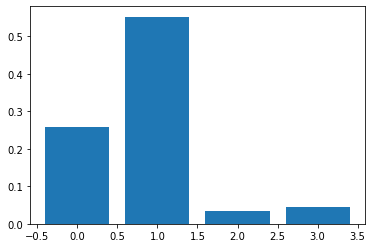

aroma is most important among all features.


In [22]:
# Another way to find important feature 
from sklearn.model_selection import train_test_split
features = df[['review_overall','review_taste','review_aroma','review_appearance','review_palette']]
X = features.drop('review_overall', axis=1)
y = features['review_overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_

for ff,ii in zip(features.columns[1:],importance):
    print('Feature: ',ff,' || Score: ',ii)

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

print("aroma is most important among all features.")

# 4. If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

In [23]:
avg_review = df.groupby(['beer_beerId'])['review_overall','review_taste','review_aroma',
                                        'review_appearance','review_palette','beer_ABV'].mean()
# print(type(avg_review))
top3 = pd.DataFrame(avg_review)
top3 = top3.sort_values(['review_overall', 'review_aroma','review_appearance','review_palette',
                         'review_taste','beer_ABV'], ascending=[False,False, False, False, False,False])
top3=top3[:3].reset_index()
print('I will recommend following 3 beers: ', top3['beer_beerId'].tolist())
top3

I will recommend following 3 beers:  [1734, 29423, 45944]


/home/sontakke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,beer_beerId,review_overall,review_taste,review_aroma,review_appearance,review_palette,beer_ABV
0,1734,5.0,5.0,5.0,5.0,5.0,10.0
1,29423,5.0,5.0,5.0,5.0,5.0,9.5
2,45944,5.0,5.0,5.0,5.0,5.0,9.0


# 5. Which Beer style seems to be the favorite based on reviews written by users? 

### Following are the two approaches to answer above question

##  Approach 1: using pretrained transformer model from Huggingface

In [24]:
# only 1/5 apart of the whole dataset is considered because of computational constrain
reviewTextData = df[['beer_beerId','beer_name','beer_ABV','beer_style','review_overall','review_text']]
reviewTextData = reviewTextData.loc[reviewTextData['review_overall'] > 4]
len(reviewTextData)

In [25]:
from transformers import pipeline                                                   
from torch.utils.data import Dataset                                                
import tqdm                                                                         
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer,AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased",model_max_length=512)

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name,model_max_length=512,model_max_len=512)
pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)

class MyDataset(Dataset): 
    def __init__(self,df): 
        self.text = df['review_text'].tolist()
        
    def __len__(self):                                                              
        return len(self.text)                                                                 

    def __getitem__(self, index):                                                       
        return  self.text[index]                                             


dataset = MyDataset(reviewTextData)   
batch_size=128
scores=[]   
# this will take an hour
for out in tqdm.tqdm(pipe(dataset, batch_size=batch_size, padding=True, truncation=True), total=len(dataset)):              
    scores.append(out)

In [26]:
sentiment_scores=[]
for ii in scores:
    if ii['label']=='NEGATIVE':
        sentiment_scores.append(ii['score']*(-1))
    else:
        sentiment_scores.append(ii['score'])

In [27]:
reviewTextData['sentiment_scores'] = sentiment_scores

In [30]:
reviewTextData=reviewTextData.sort_values('review_overall', ascending=False)
reviewTextData[:5]

,beer_beerId,beer_name,beer_ABV,beer_style,review_overall,review_text,senti_scores
77010,846,Samuel Adams Scotch Ale,5.4,Scotch Ale / Wee Heavy,5.0,"Cool tartan ""kilt"" pattern bottle with our fri...",0.991981
115943,1585,Raspberry Tart,4.0,Fruit / Vegetable Beer,5.0,Basically a perfect beer experience -- excepti...,0.999142
28046,1607,Sierra Nevada India Pale Ale,6.8,English India Pale Ale (IPA),5.0,"This is my first review for BA, so I should ma...",0.993469
116191,56738,Moon Man,5.0,American Pale Ale (APA),5.0,[L] Moon man pours a golden color with a spott...,0.992489
60019,11922,Titan IPA,7.1,American IPA,5.0,A- Almost a tan orange color. Great carbonatio...,0.998819


In [31]:
reviewTextDataGrp = reviewTextData.groupby('beer_style')['senti_scores'].mean()
reviewTextDataGrp.sort_values(ascending=False)[0:10]

beer_style
Happoshu                        0.999603
American Dark Wheat Ale         0.991594
Gose                            0.980877
Chile Beer                      0.941301
Dortmunder / Export Lager       0.924558
Belgian IPA                     0.918587
Vienna Lager                    0.917280
Rye Beer                        0.915521
Czech Pilsener                  0.915015
English India Pale Ale (IPA)    0.907575
Name: senti_scores, dtype: float64

In [28]:
df1=pd.read_csv('/home/sontakke/Desktop/job/BeerDataScienceProject_sentiment.csv')

In [29]:
reviewTextData=df1

## Approach 2: using Sentiment Analyzer from NLTK

In [38]:
reviewTextData = df[['beer_beerId','beer_name','beer_ABV','beer_style','review_overall','review_text']]
# reviewTextData = reviewTextData.loc[reviewTextData['review_overall'] >= 4]
reviewTextData.reset_index(inplace=True)
len(reviewTextData)

502691

In [39]:
import re
def deconstruct(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    return phrase

In [40]:
preprocessed_reviews = []
for sentance in (reviewTextData['review_text'].values): 
    sentance = deconstruct(sentance) 
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    preprocessed_reviews.append(sentance) 

In [41]:
reviewTextData['preprocessed_text'] = preprocessed_reviews

/home/sontakke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sontakke/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [43]:
# Instantiating Sentiment Analyzer
senti = SentimentIntensityAnalyzer()

In [44]:
reviewTextData['polarity_score'] = reviewTextData['preprocessed_text'].apply(lambda x: senti.polarity_scores(x)['compound'])


/home/sontakke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
reviewTextDataGrp = reviewTextData.groupby('beer_style')['polarity_score'].mean()
reviewTextDataGrp.sort_values(ascending=False)[0:10]

beer_style
Quadrupel (Quad)                    0.856687
Dortmunder / Export Lager           0.852883
Flanders Red Ale                    0.851888
Roggenbier                          0.851769
Braggot                             0.850409
Kvass                               0.850273
American Double / Imperial Stout    0.847080
Wheatwine                           0.840098
Eisbock                             0.836985
Belgian Strong Dark Ale             0.832818
Name: polarity_score, dtype: float64

In [46]:
print("Quadrupel (Quad) is the beer style seems to be the favorite based on reviews written by users")

Quadrupel (Quad) is the beer style seems to be the favorite based on reviews written by users


# 6. How does written review compare to overall review score for the beer styles?

In [47]:
compare = reviewTextData.groupby('beer_style')['polarity_score','review_overall'].mean()
                                            
compare = pd.DataFrame(compare.reset_index()).sort_values(['polarity_score','review_overall'], ascending=[False,False])
compare[:10]

/home/sontakke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,beer_style,polarity_score,review_overall
86,Quadrupel (Quad),0.856687,4.053349
38,Dortmunder / Export Lager,0.852883,4.071470
58,Flanders Red Ale,0.851888,3.968012
88,Roggenbier,0.851769,4.054745
32,Braggot,0.850409,3.647208
72,Kvass,0.850273,4.025773
11,American Double / Imperial Stout,0.847080,4.101682
101,Wheatwine,0.840098,3.817614
41,Eisbock,0.836985,4.082902
25,Belgian Strong Dark Ale,0.832818,4.010903


By comparing overall review score with the written reviews, overall scores is more than 4 for most of the top beer style

# 7. How do find similar beer drinkers by using written reviews only?   

In [36]:
len(set(df['review_profileName']))

22563

In [37]:
df['review_text'][0]

'A lot of foam. But a lot. In the smell some banana, and then lactic and tart. Not a good start. Quite dark orange in color, with a lively carbonation (now visible, under the foam). Again tending to lactic sourness. Same for the taste. With some yeast and banana.'

In [9]:
#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
df = df.sample(frac=1).reset_index()
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(df['review_text'][:100000])

In [35]:
# # KMean clustering to cluster similar drinkers based on their review
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# Sum_of_squared_distances = []
# K = range(2,10)
# for k in K:
#     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
#     km = km.fit(X)
#     Sum_of_squared_distances.append(km.inertia_)
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Taking 10 clusters
km1=KMeans(n_clusters=10,  max_iter=200, n_init=10)
km1.fit(X)

y=km1.predict(X)

df = df[:100000]
df["label"] = y
df.head()

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,label
0,124516,9.0,59770,273,Sweetwater Dank Tank Magnum IP,American Double / Imperial Pilsner,4.0,4.0,4.0,4.0,BeerAdvocate,4.0,Review from BeerAdvocate Magazine Issue #43 (A...,1294717864,3
1,257573,9.0,4718,841,Vapeur Cochonne,Belgian Strong Dark Ale,3.0,3.0,3.5,3.5,Tone,3.5,"Pours a cloudy, brown color. 3/4 inch head of ...",1294790381,7
2,168697,7.0,2751,610,Racer 5 India Pale Ale,American IPA,4.0,4.5,4.0,4.5,CuttDeez,4.0,A- very nice golden amber pour with an incredi...,1295877725,2
3,423853,8.0,7728,697,Hitachino Nest Extra High (XH),Belgian Strong Dark Ale,4.5,4.5,4.5,4.0,brentk56,4.5,Appearance: Pours a cloudy amber color with a ...,1226708551,5
4,270913,6.2,17009,68,Heller Hound Bock Beer,Maibock / Helles Bock,4.0,3.0,2.5,3.0,jdhilt,3.0,Pours a three finger white head that fades qui...,1166397868,9


In [11]:
#members of cluster 1 (similar drinkers)
df[df['label']==1][:5]

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,label
8,422445,5.8,226,73,Great Lakes Edmund Fitzgerald Porter,American Porter,4.5,4.0,4.0,4.0,Goblinmunkey7,4.0,Appearance: Deep dark brown. Nice and clear as...,1322865343,1
9,131917,10.0,34203,5318,Santa's Little Helper,Russian Imperial Stout,5.0,4.5,4.0,5.0,Crosling,4.5,Bottle # 411. It has a definately Belgian aspe...,1142733112,1
20,180060,12.0,3833,396,AleSmith Speedway Stout,American Double / Imperial Stout,4.0,4.0,4.5,4.0,Beejay,4.5,"A: Obsidian Black. Fairly little head, what is...",1282530922,1
25,253919,9.5,10325,1141,Péché Mortel (Imperial Stout Au Cafe),American Double / Imperial Stout,4.0,3.5,4.5,4.5,beerthulhu,4.5,A: Pitch black in the glass was topped off by ...,1270506622,1
31,312071,4.9,1879,35,Samuel Adams Cream Stout,Milk / Sweet Stout,4.0,4.0,4.5,4.0,mschofield,4.5,"Deep brown (near black) with ruby fringe, 4 fi...",1069778654,1
